In [72]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import zscore
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from math import sin, cos, sqrt, atan2, radians
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("Arrest_Data_from_2010_to_Present.csv", sep=",")

In [74]:
#1 How many bookings of arrestees were made in 2018?
#df["Arrest Date"] = df["Arrest Date"].astype("datetime64[ns]")
df["Arrest Date"] = pd.to_datetime(df['Arrest Date']) 

df['arrest_year'] = df['Arrest Date'].map(lambda x: x.strftime('%Y'))
print(df[df.arrest_year == "2018"].shape) # Answer: 104277 (104277, 18)

(104277, 18)


In [ ]:
#2 How many bookings of arrestees were made in the area with the most arrests in 2018?
#df_2018 = df[df.arrest_year == "2018"]
df_2018.groupby(["Area ID"]).size() # Answer: Area ID 1) 10951


In [ ]:
#3 What is the 95% quantile of the age of the arrestee in 2018?
#  Only consider the following charge groups for your analysis: Vehicle Theft, Robbery, Burglary, Receive Stolen Property
#df_2018 = df[df.arrest_year == "2018"]
#df_2018filtered = df_2018[df_2018['Charge Group Description'].isin(["Vehicle Theft", "Robbery", "Burglary", "Receive Stolen Property"])]

df_2018filtered['Age'].describe()
df_2018filtered['Age'].quantile([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,  0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
print(df_2018filtered['Age'].quantile(0.95)) # Answer: 52

In [ ]:
#4 There are differences between the average age of an arrestee for the various charge groups. Are these differences statistically significant? For this question, calculate the Z-score of the average
#  age for each charge group. Report the largest absolute value among the calculated Z-scores: Only consider data for 2018, Do not consider "Pre-Delinquency" and "Non-Criminal Detention" as these charge 
#  groups are reserved for minors, Exclude any arrests where the charge group description is not known

df_2018 = df[df.arrest_year == "2018"]
df_2018filtered = df_2018.loc[~df_2018['Charge Group Description'].isin(["Non-Criminal Detention","Pre-Delinquency"])] # exclude charge groups reserved for minors
df_2018filtered = df_2018filtered.dropna(subset=["Charge Group Description"])


# z score is defined as: z= (x-mean)/std    not that x is the mean age of an arreste for each group and mean is the age mean of the whole population similiar is std the standard deviation for the whole population
(df_2018filtered.groupby("Charge Group Description")["Age"].mean()-df_2018filtered["Age"].mean())/df_2018filtered["Age"].std() #this gives the z score for each category 
max((df_2018filtered.groupby("Charge Group Description")["Age"].mean()-df_2018filtered["Age"].mean())/df_2018filtered["Age"].std()) #the maximum z score has the group Drunkeness with 0.693428

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


31038.0


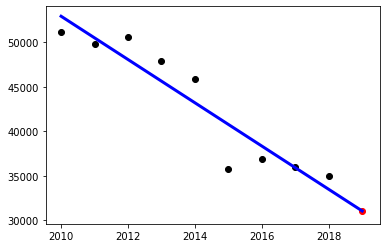

In [124]:
#5 Felony arrest incidents have been dropping over the years. Using a trend line (linear estimation) for the data from 2010 and 2018 (inclusive), what is the projected number of felony arrests in 2019? Round to the
#  nearest integer. Note, the data set includes arrests for misdemeanor, felonies, etc.
df_F = df[df["Arrest Type Code"] == "F"]
df_F = df_F[(df_F.arrest_year < "2019") & (df.arrest_year >= "2010")]
df_felonyarrestsperyear = df_F.groupby(df_F["arrest_year"]).size()
df_felonyarrestsperyear = pd.DataFrame(df_arrestsperyear).reset_index()

reg = linear_model.LinearRegression()
reg.fit(df_felonyarrestsperyear["arrest_year"].values.reshape(-1,1), df_felonyarrestsperyear[0])
in_sample_predictions = reg.predict(df_felonyarrestsperyear["arrest_year"].values.reshape(-1,1))
prediction_2019 = reg.predict(np.array(2019).reshape(-1,1))

#plot results
plt.scatter(df_felonyarrestsperyear["arrest_year"].values.astype("float64"), df_felonyarrestsperyear[0].values.astype("float64"), color="black")
plt.plot(np.arange(2010,2020,1).astype("float64"), reg.predict(np.arange(2010,2020,1).reshape(-1,1)).astype("float64"),  color='blue', linewidth=3)
plt.scatter(2019,prediction_2019,color="red")

print(round(prediction_2019[0])) #Answer: 31038

In [ ]:
#6 How many arrest incidents occurred within 2 km from the Bradbury Building in 2018? Use (34.050536, -118.247861) for the coordinates of the Bradbury Building . For simplicity, please use the spherical Earth projected
#  to a plane equation for calculating distances. Use the radius of the Earth as 6371 km. Note, some arrest records are missing location data and the location is listed as (0, 0). These records should not factor in your calculation.


df = df[df.Location != "(0, 0)"]
df['latlon'] = df.Location.apply(lambda x: x[1:][:-1].split(','))

distance_list = []
R = 6371
lat1 = radians(34.050536)
lon1 = radians(-118.247861)


for i in df.latlon: 
    

    lat2 = radians(float(i[0]))
    lon2 = radians(float(i[1]))
    
    dist_lat = lat1-lat2
    dist_lon = lon1-lon2
    meanlat1 = (lat1+lat2)/2
    
    D = R*sqrt((dist_lat**2)+(cos(meanlat1)*dist_lon)**2)
    distance_list.append(D)

df["distance"] = distance_list    
df_in2kmdistance = df[df.distance <= 2]

print(df_in2kmdistance.shape[0]) # Answer: 138694 (138694, 19)

In [ ]:
#7 How many arrest incidents were made per kilometer on Pico Boulevard during 2018? For this question, we will need to estimate the length of Pico Boulevard, which mostly stretches from east to west.
#  To estimate the length of Pico Boulevard:
#     - Consider all location data which the listed address mentions "Pico".
#     - Remove outliers by filtering out locations where either the latitude or longitude is 2 standard deviations beyond the mean of the subset of identified points.
#     - To estimate the length, calculate the distance from the most western and eastern coordinate points. Use the spherical Earth projected to a plane equation for calculating distances.
#   Once you have estimated the length of Pico Boulevard, you can proceed to report the number of arrest incidents per kilometer on Pico Boulevard in 2018.

df["lat"] = df.latlon.apply(lambda x: x[0])
df["lon"] = df.latlon.apply(lambda x: x[1])
df_pico = df[df['Address'].str.contains("PICO")]
lat_mean = np.mean(df_pico['lat'].astype("float64").values)
lon_mean = np.mean(df_pico['lon'].astype("float64").values)
lat_std = np.std(df_pico['lat'].astype("float64").values)
lon_std = np.std(df_pico['lon'].astype("float64").values)

upper_boundary_lat = lat_mean + lat_std*2
lower_boundary_lat = lat_mean - lat_std*2
upper_boundary_lon = lon_mean + lon_std*2
lower_boundary_lon = lon_mean - lon_std*2

df_pico = df_pico[(df_pico.lat.astype("float64") >= lower_boundary_lat) & (df_pico.lat.astype("float64") <= upper_boundary_lat)]
df_pico = df_pico[(df_pico.lon.astype("float64") >= lower_boundary_lon) & (df_pico.lon.astype("float64") <= upper_boundary_lon)]


#now we need the most western and eastern coordinates assosiated with "Pico" most_western -> max(lon) most_eastern -> min(lon)
lon_pico1 = radians(float(df_pico.lon.max()))
lon_pico2 = radians(float(df_pico.lon.min()))
lat_pico1 = radians(float(df_pico[df_pico.lon == df_pico.lon.max()].lat.values[0]))
lat_pico2 = radians(float(df_pico[df_pico.lon == df_pico.lon.min()].lat.values[0]))


dist_lat_pico = lat_pico1-lat_pico2
dist_lon_pico = lon_pico1-lon_pico2
meanlat1_pico = (lat_pico1+lat_pico2)/2
R = 6371
    
length_pico_boulevard = R*sqrt((dist_lat_pico**2)+(cos(meanlat1_pico)*dist_lon_pico)**2)

print(length_pico_boulevard) #Answer: 37.42871597183754

In [71]:
#8 Some types of arrest incidents in certain areas occur at a highly disproportionate rate compared to their frequency city-wide. For example, let's say that the rate of larceny arrests (charge group code 6) is 1% in Devonshire (area ID 17).
#   This rate may appear low but what if larceny arrests constitute 0.1 % city-wide? The ratio between these two probabilities is 10 and we can say that larceny occurs unusually often in Devonshire (Note, these numbers were made up for illustration purposes).
#   Calculate this ratio for all charge group code and area ID pairs. You can view this ratio as the ratio of the conditional probability of an arrest incident of a charge group code given that it occurred in an area ID to the unconditional probability of the arrest incident of a charge group.
#   Report the average of the top 5 of the calculated ratio.
#   (Consider all records prior to January 1, 2019 ,Some arrest incidents don't have a charge group code. These records should not be considered in your analysis, Arrest incidents for charge group code 99 should not be considered in your analysis.)

# df_f stands for dataframe filtered

#df["Arrest Date"] = pd.to_datetime(df['Arrest Date']) 
df_f = df[(df["Arrest Date"] < "2019-01-01")]
df_f = df_f.dropna(subset=["Charge Group Code"])
df_f = df_f[df_f["Charge Group Code"] != 99]

ratio_list = []
number_of_incidents = df_f.shape[0]
for i in df_f["Charge Group Code"].unique():
    number_of_incidents_chargegroup = df_f[df_f["Charge Group Code"] == i].shape[0]
    ratio_chargegroup_total = number_of_incidents_chargegroup/number_of_incidents
    df_f_chargecode = df_f[df_f["Charge Group Code"] == i]
    for j in df_f["Area ID"].unique():
        number_of_incidents_area = df_f[df_f["Area ID"] == j].shape[0]
        number_of_incidents_area_chargecode = df_f_chargecode[df_f_chargecode["Area ID"] == j].shape[0]
        ratio_chargegroup_area = number_of_incidents_area_chargecode/number_of_incidents_area
        ratio = ratio_chargegroup_area/ratio_chargegroup_total
        #print([i,j], ratio)
        ratio_list.append(ratio)
print(pd.Series(ratio_list).nlargest(5).mean()) #Answer: 3.515076379865202

3.515076379865202
